In [1]:
import numpy as np
import matplotlib.pyplot as plt

% matplotlib inline

In [2]:
Xy_numu = np.load("Xy_numu.npz")
Xy_nue = np.load("Xy_nue.npz")

In [3]:
X_numu = Xy_numu["x"]
y_numu = Xy_numu["y"]

In [4]:
X_nue = Xy_nue["x"]
y_nue = Xy_nue["y"]

np.save("X_numu.npy",X_numu)
np.save("Y_numu.npy",Y_numu)
np.save("X_nue.npy",X_nue)
np.save("Y_nue.npy",Y_nue)

In [5]:
print('X_numu: ', X_numu.shape, 'X_nue: ', X_nue.shape, 'y_numu: ', y_numu.shape, 'y_nue: ', y_nue.shape)

('X_numu: ', (1541, 75, 16, 15, 18), 'X_nue: ', (1183, 75, 16, 15, 18), 'y_numu: ', (1541,), 'y_nue: ', (1183,))


In [6]:
X = np.vstack((X_numu, X_nue))

In [7]:
y = np.hstack((y_numu, y_nue))

In [8]:
import keras

Using TensorFlow backend.


In [9]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

In [10]:
get_available_gpus()

[u'/gpu:0']

In [11]:
keras.backend.image_data_format()

'channels_first'

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

In [13]:
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.optimizers import SGD
from keras.layers.convolutional import Conv3D, MaxPooling3D, ZeroPadding3D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.losses import categorical_crossentropy

In [14]:
from history_plot import history_plot

In [15]:
print("X size: %d, y size: %d" %(X.shape[0], y.shape[0]) )

X size: 2724, y size: 2724


In [16]:
indices = np.arange(X.shape[0])
X_train, X_test, y_train, y_test, indx_train, indx_test = train_test_split(X, y, indices, test_size=0.20, 
                                                                           random_state=42, stratify=y)

In [17]:
print(X_train.shape, y_train.shape, indx_train.shape)
print(X_test.shape, y_test.shape, indx_test.shape)

((2179, 75, 16, 15, 18), (2179,), (2179,))
((545, 75, 16, 15, 18), (545,), (545,))


In [18]:
# Check that Stratification worked
print(y[y==0].shape, y_train[y_train==0].shape, y_test[y_test==0].shape)
print(y[y==1].shape, y_train[y_train==1].shape, y_test[y_test==1].shape)

((1183,), (946,), (237,))
((1541,), (1233,), (308,))


In [19]:
img_channel = X_train.shape[1]
conv_dim_1 = X_train.shape[2]
conv_dim_2 = X_train.shape[3]
conv_dim_3 = X_train.shape[4]
inputshape = (img_channel, conv_dim_1, conv_dim_2, conv_dim_3)
print(inputshape)

(75, 16, 15, 18)


##### Setup Model Callbacks

In [20]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=1e-4, verbose=1)

early_stop_noval = EarlyStopping(monitor='loss', patience=5, verbose=1)
reduce_lr_noval = ReduceLROnPlateau(monitor='loss', factor=0.1,
                              patience=2, min_lr=1e-4, verbose=1)

#### Create Deep Network Model

In [21]:
def cnn_model(num_classes, optimizer):
    model = Sequential()
    model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', input_shape=inputshape))
    model.add(Conv3D(64, (3, 3, 3), activation='relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(0.1))
    model.add(Conv3D(32, (3, 3, 3), activation='relu'))
    model.add(Dropout(0.25))
    model.add(Conv3D(32, (3, 3, 3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(256,activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss=categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])
    return model

In [22]:
from keras.backend import clear_session

def cross_validation_score(K, N, X_train, y_train, f_model, f_args, fit_args):
    """"""
    iteration_tr_score = list()
    iteration_val_score = list()
    histories_cnn = list()
    
    def iteration_metrics(scores):
        mean_score = np.mean(scores)
        min_score = np.min(scores)
        max_score = np.max(scores)
        return mean_score, min_score, max_score
    
    for iteration in range(N):
        tr_accuracy_scores = list()
        val_accuracy_scores=list()
        
        skf = StratifiedKFold(n_splits=K, random_state=iteration)
        
        for i, (train_index, validation_index) in enumerate(skf.split(X_train, y_train)):
            print("[Iteration %d/%d] Test nr.: %d/%d" % (iteration+1, N, i+1, K))
            
            Xtrain, Xvalidation = X_train[train_index], X_train[validation_index]
            ytrain, yvalidation = y_train[train_index], y_train[validation_index]

            model = f_model(**f_args)
            
            if iteration == 0 and i == 0:
                model.summary()
            
            Ytrain = to_categorical(ytrain)
            Yvalidation = to_categorical(yvalidation)
            history = model.fit(Xtrain, Ytrain, validation_data = (Xvalidation, Yvalidation), 
                                shuffle=False, **fit_args) 
                        
            histories_cnn.append(history)
            training_acc = history.history['acc'][-1]
            validation_acc = history.history['val_acc'][-1]
            
            print("\nTraining acc: %f, Validation acc: %f\n" %(training_acc,validation_acc))
            tr_accuracy_scores.append(training_acc)
            val_accuracy_scores.append(validation_acc)
            
        iteration_tr_score.append(iteration_metrics(tr_accuracy_scores))
        iteration_val_score.append(iteration_metrics(val_accuracy_scores))
        
    clear_session()
        
    print("Training metrics: ")
    print("ITER \t MEAN \t MIN \t MAX")
    for it, metric in enumerate(iteration_tr_score):
        print("{0:d} \t {1:.3f} \t {2:.3f} \t {3:.3f}".format(it+1, *metric))
    
    print("Validation metrics: ")
    print("ITER \t MEAN \t MIN \t MAX")
    for it, metric in enumerate(iteration_val_score):
        print("{0:d} \t {1:.3f} \t {2:.3f} \t {3:.3f}".format(it+1, *metric))

    return histories_cnn

In [23]:
fargs = {'num_classes': 2, 'optimizer': keras.optimizers.Adadelta()}
fitargs = {'batch_size': 64, 'epochs': 30, 'callbacks': [early_stop], 'verbose': 1}
history_info = cross_validation_score(K=3, N=1, X_train=X_train, y_train=y_train, 
                                      f_model=cnn_model, f_args=fargs, fit_args=fitargs)

[Iteration 1/1] Test nr.: 1/3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 128, 14, 13, 16)   259328    
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 64, 12, 11, 14)    221248    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 64, 6, 5, 7)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 6, 5, 7)       0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 32, 4, 3, 5)       55328     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 4, 3, 5)       0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 32, 2, 1, 

ResourceExhaustedError: OOM when allocating tensor with shape[64,16,15,18,75]
	 [[Node: conv3d_1/transpose = Transpose[T=DT_FLOAT, Tperm=DT_INT32, _device="/job:localhost/replica:0/task:0/gpu:0"](_arg_conv3d_1_input_0_0/_19, conv3d_1/transpose/perm)]]
	 [[Node: loss/mul/_45 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_1433_loss/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op u'conv3d_1/transpose', defined at:
  File "/usr/lib/python2.7/runpy.py", line 162, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python2.7/dist-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python2.7/dist-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2718, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2822, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-23-75f59ef41556>", line 4, in <module>
    f_model=cnn_model, f_args=fargs, fit_args=fitargs)
  File "<ipython-input-22-721705fa8e3d>", line 27, in cross_validation_score
    model = f_model(**f_args)
  File "<ipython-input-21-5c6d78584e90>", line 3, in cnn_model
    model.add(Conv3D(128, kernel_size=(3, 3, 3), activation='relu', input_shape=inputshape))
  File "/usr/local/lib/python2.7/dist-packages/keras/models.py", line 442, in add
    layer(x)
  File "/usr/local/lib/python2.7/dist-packages/keras/engine/topology.py", line 602, in __call__
    output = self.call(inputs, **kwargs)
  File "/usr/local/lib/python2.7/dist-packages/keras/layers/convolutional.py", line 172, in call
    dilation_rate=self.dilation_rate)
  File "/usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py", line 3305, in conv3d
    x = _preprocess_conv3d_input(x, data_format)
  File "/usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py", line 2996, in _preprocess_conv3d_input
    x = tf.transpose(x, (0, 2, 3, 4, 1))
  File "/home/cdesio/.local/lib/python2.7/site-packages/tensorflow/python/ops/array_ops.py", line 1303, in transpose
    ret = gen_array_ops.transpose(a, perm, name=name)
  File "/home/cdesio/.local/lib/python2.7/site-packages/tensorflow/python/ops/gen_array_ops.py", line 3887, in transpose
    result = _op_def_lib.apply_op("Transpose", x=x, perm=perm, name=name)
  File "/home/cdesio/.local/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/home/cdesio/.local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/cdesio/.local/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[64,16,15,18,75]
	 [[Node: conv3d_1/transpose = Transpose[T=DT_FLOAT, Tperm=DT_INT32, _device="/job:localhost/replica:0/task:0/gpu:0"](_arg_conv3d_1_input_0_0/_19, conv3d_1/transpose/perm)]]
	 [[Node: loss/mul/_45 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_1433_loss/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [28]:
len(history_info)

30

In [61]:
import history_plot
reload(history_plot)

<module 'history_plot' from 'history_plot.py'>

In [50]:
%matplotlib inline

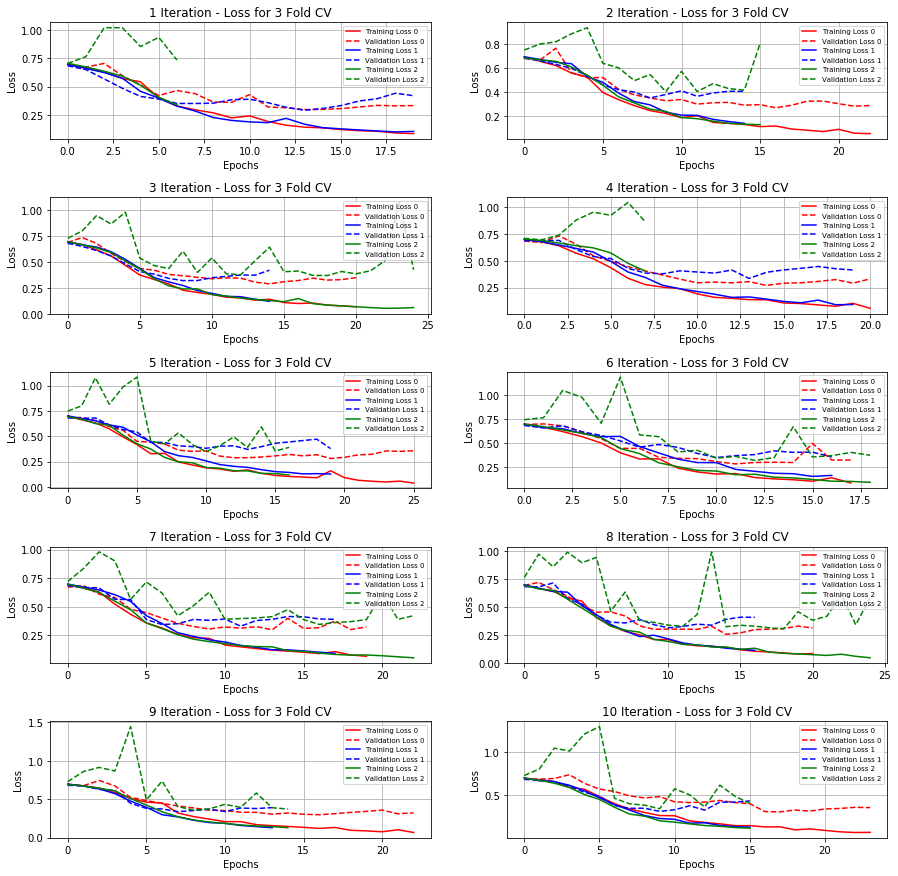

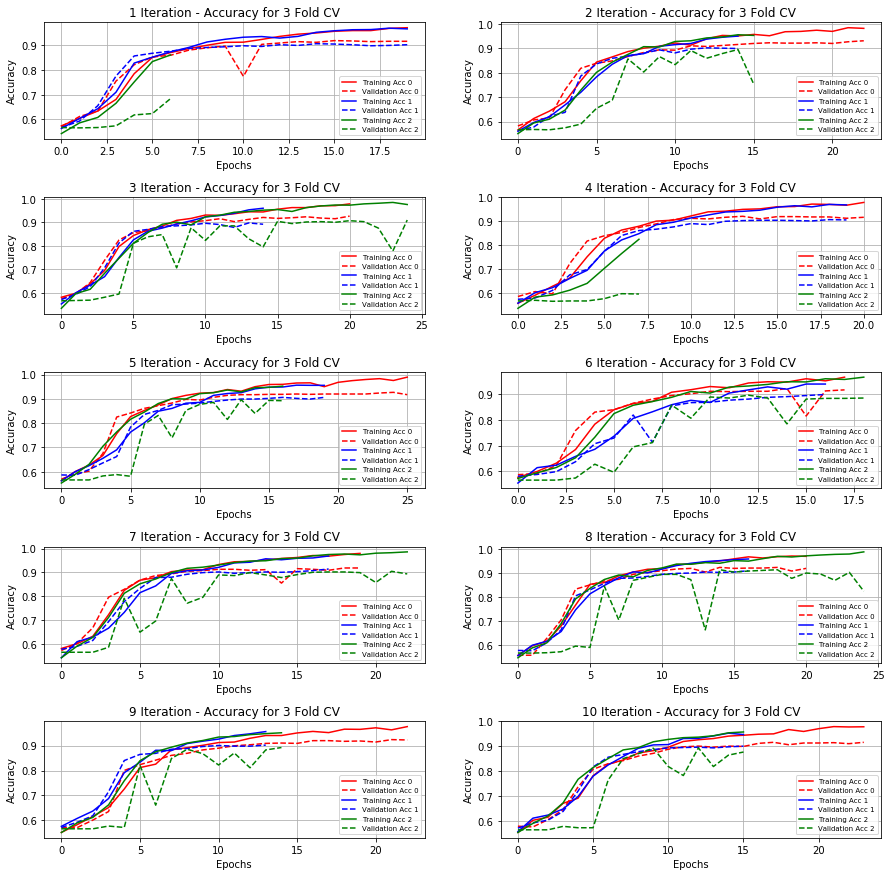

In [55]:
history_plot.history_plot_cv(history_info, K=3, N=10)

In [56]:
fargs = {'num_classes': 2, 'optimizer': keras.optimizers.Adadelta()}
fitargs = {'batch_size': 128, 'epochs': 50, 'callbacks': [early_stop], 'verbose': 1}
history_info_128 = cross_validation_score(K=3, N=10, X_train=X_train, y_train=y_train, 
                                      f_model=cnn_model, f_args=fargs, fit_args=fitargs)

[Iteration 1/10] Test nr.: 1/3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 128, 14, 13, 16)   259328    
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 64, 12, 11, 14)    221248    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 64, 6, 5, 7)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 6, 5, 7)       0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 32, 4, 3, 5)       55328     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 4, 3, 5)       0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 32, 2, 1,

1452/1452 [==============================] - 9s - loss: 0.6722 - acc: 0.5916 - val_loss: 0.6704 - val_acc: 0.5901
Epoch 4/50
1452/1452 [==============================] - 9s - loss: 0.6099 - acc: 0.6405 - val_loss: 0.6515 - val_acc: 0.6396
Epoch 5/50
1452/1452 [==============================] - 8s - loss: 0.5609 - acc: 0.6915 - val_loss: 0.6280 - val_acc: 0.6960
Epoch 6/50
1452/1452 [==============================] - 9s - loss: 0.4969 - acc: 0.7590 - val_loss: 0.5675 - val_acc: 0.8171
Epoch 7/50
1452/1452 [==============================] - 8s - loss: 0.4382 - acc: 0.8209 - val_loss: 0.5840 - val_acc: 0.7978
Epoch 8/50
1452/1452 [==============================] - 8s - loss: 0.3885 - acc: 0.8499 - val_loss: 0.4924 - val_acc: 0.8569
Epoch 9/50
1452/1452 [==============================] - 8s - loss: 0.3353 - acc: 0.8822 - val_loss: 0.4714 - val_acc: 0.8514
Epoch 10/50
1452/1452 [==============================] - 9s - loss: 0.2935 - acc: 0.8919 - val_loss: 0.4614 - val_acc: 0.8528
Epoch 11/5

1453/1453 [==============================] - 9s - loss: 0.1090 - acc: 0.9601 - val_loss: 0.3753 - val_acc: 0.8967
Epoch 23/50
1453/1453 [==============================] - 9s - loss: 0.1102 - acc: 0.9566 - val_loss: 0.4855 - val_acc: 0.8926
Epoch 24/50
1453/1453 [==============================] - 9s - loss: 0.0998 - acc: 0.9635 - val_loss: 0.3605 - val_acc: 0.8994
Epoch 25/50
1453/1453 [==============================] - 9s - loss: 0.1002 - acc: 0.9635 - val_loss: 0.8105 - val_acc: 0.7961
Epoch 00024: early stopping

Training acc: 0.963524, Validation acc: 0.796143

[Iteration 5/10] Test nr.: 1/3
Train on 1452 samples, validate on 727 samples
Epoch 1/50
1452/1452 [==============================] - 9s - loss: 0.6971 - acc: 0.5702 - val_loss: 0.6917 - val_acc: 0.5708
Epoch 2/50
1452/1452 [==============================] - 9s - loss: 0.6806 - acc: 0.5882 - val_loss: 0.6868 - val_acc: 0.5832
Epoch 3/50
1452/1452 [==============================] - 9s - loss: 0.6647 - acc: 0.6040 - val_loss: 0

Train on 1452 samples, validate on 727 samples
Epoch 1/50
1452/1452 [==============================] - 9s - loss: 0.6967 - acc: 0.5751 - val_loss: 0.6962 - val_acc: 0.5612
Epoch 2/50
1452/1452 [==============================] - 8s - loss: 0.6788 - acc: 0.5944 - val_loss: 0.6945 - val_acc: 0.5708
Epoch 3/50
1452/1452 [==============================] - 8s - loss: 0.6584 - acc: 0.6047 - val_loss: 0.7038 - val_acc: 0.5750
Epoch 4/50
1452/1452 [==============================] - 8s - loss: 0.6398 - acc: 0.6226 - val_loss: 0.6925 - val_acc: 0.5997
Epoch 5/50
1452/1452 [==============================] - 8s - loss: 0.6438 - acc: 0.6377 - val_loss: 0.6960 - val_acc: 0.6135
Epoch 6/50
1452/1452 [==============================] - 8s - loss: 0.5548 - acc: 0.6825 - val_loss: 0.7434 - val_acc: 0.6011
Epoch 7/50
1452/1452 [==============================] - 8s - loss: 0.5469 - acc: 0.6928 - val_loss: 0.6731 - val_acc: 0.7208
Epoch 8/50
1452/1452 [==============================] - 8s - loss: 0.5134 - ac

1452/1452 [==============================] - 8s - loss: 0.4640 - acc: 0.7720 - val_loss: 0.6015 - val_acc: 0.7937
Epoch 9/50
1452/1452 [==============================] - 8s - loss: 0.4126 - acc: 0.8258 - val_loss: 0.6357 - val_acc: 0.7565
Epoch 10/50
1452/1452 [==============================] - 8s - loss: 0.3666 - acc: 0.8526 - val_loss: 0.6300 - val_acc: 0.7607
Epoch 11/50
1452/1452 [==============================] - 8s - loss: 0.3252 - acc: 0.8526 - val_loss: 0.4687 - val_acc: 0.8459
Epoch 12/50
1452/1452 [==============================] - 8s - loss: 0.2904 - acc: 0.8891 - val_loss: 0.4532 - val_acc: 0.8597
Epoch 13/50
1452/1452 [==============================] - 8s - loss: 0.2372 - acc: 0.9043 - val_loss: 0.4385 - val_acc: 0.8721
Epoch 14/50
1452/1452 [==============================] - 8s - loss: 0.2493 - acc: 0.8953 - val_loss: 0.4004 - val_acc: 0.8624
Epoch 15/50
1452/1452 [==============================] - 8s - loss: 0.2062 - acc: 0.9139 - val_loss: 0.3592 - val_acc: 0.8900
Epoch

1453/1453 [==============================] - 8s - loss: 0.6160 - acc: 0.6380 - val_loss: 0.6186 - val_acc: 0.6240
Epoch 5/50
1453/1453 [==============================] - 8s - loss: 0.6074 - acc: 0.6524 - val_loss: 0.5652 - val_acc: 0.6570
Epoch 6/50
1453/1453 [==============================] - 8s - loss: 0.5264 - acc: 0.7398 - val_loss: 0.5270 - val_acc: 0.8030
Epoch 7/50
1453/1453 [==============================] - 8s - loss: 0.4762 - acc: 0.7949 - val_loss: 0.4556 - val_acc: 0.8444
Epoch 8/50
1453/1453 [==============================] - 8s - loss: 0.3931 - acc: 0.8362 - val_loss: 0.3922 - val_acc: 0.8595
Epoch 9/50
1453/1453 [==============================] - 8s - loss: 0.3313 - acc: 0.8699 - val_loss: 0.3753 - val_acc: 0.8705
Epoch 10/50
1453/1453 [==============================] - 8s - loss: 0.2838 - acc: 0.8837 - val_loss: 0.3753 - val_acc: 0.8843
Epoch 11/50
1453/1453 [==============================] - 8s - loss: 0.3145 - acc: 0.8658 - val_loss: 0.3440 - val_acc: 0.8871
Epoch 12/

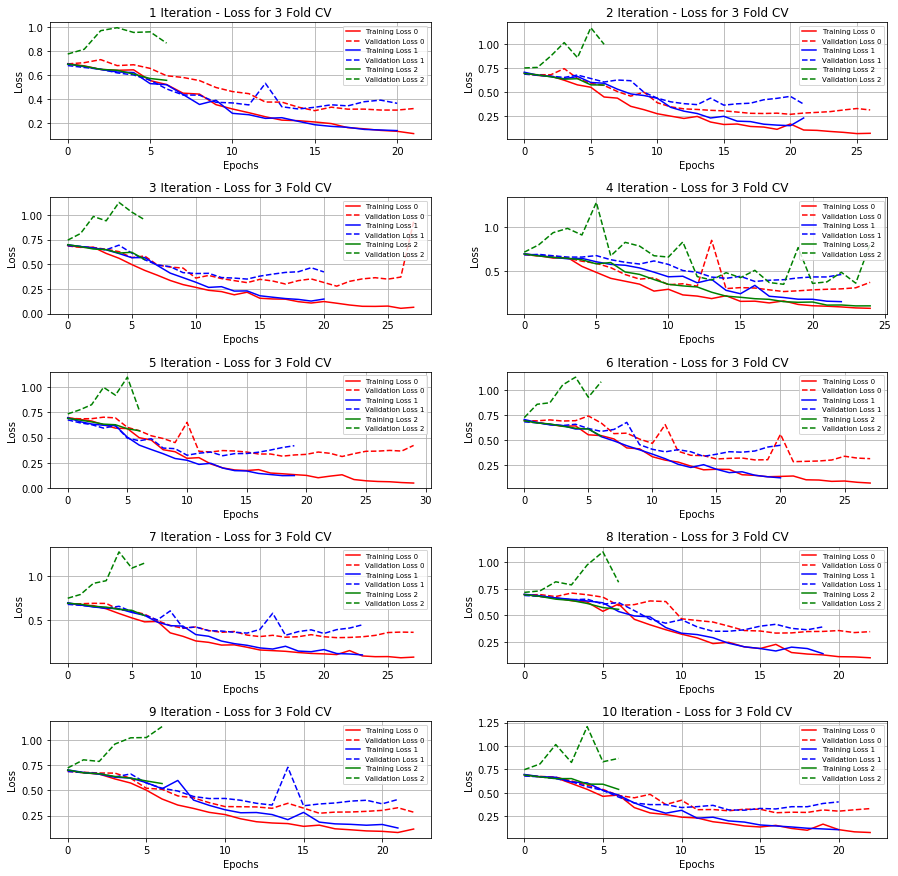

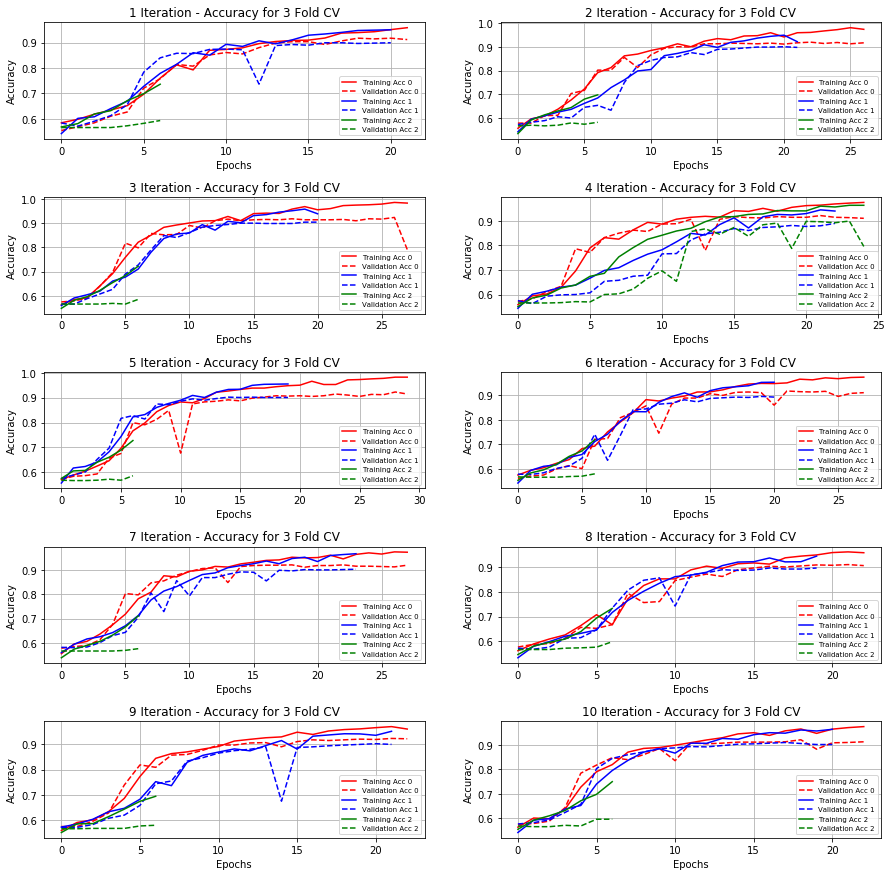

In [62]:
history_plot.history_plot_cv(history_info_128, "", "show", K=3, N=10)

[Iteration 1/2] Test nr.: 1/3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 128, 14, 13, 16)   259328    
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 64, 12, 11, 14)    221248    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 64, 6, 5, 7)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 6, 5, 7)       0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 32, 4, 3, 5)       55328     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 4, 3, 5)       0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 32, 2, 1, 

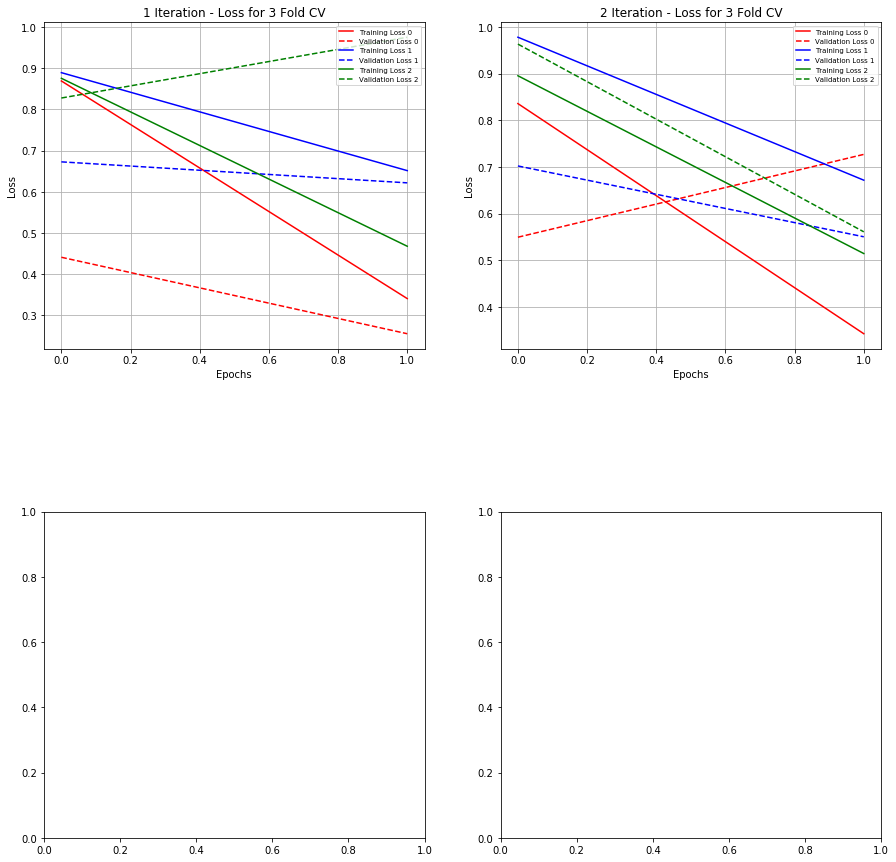

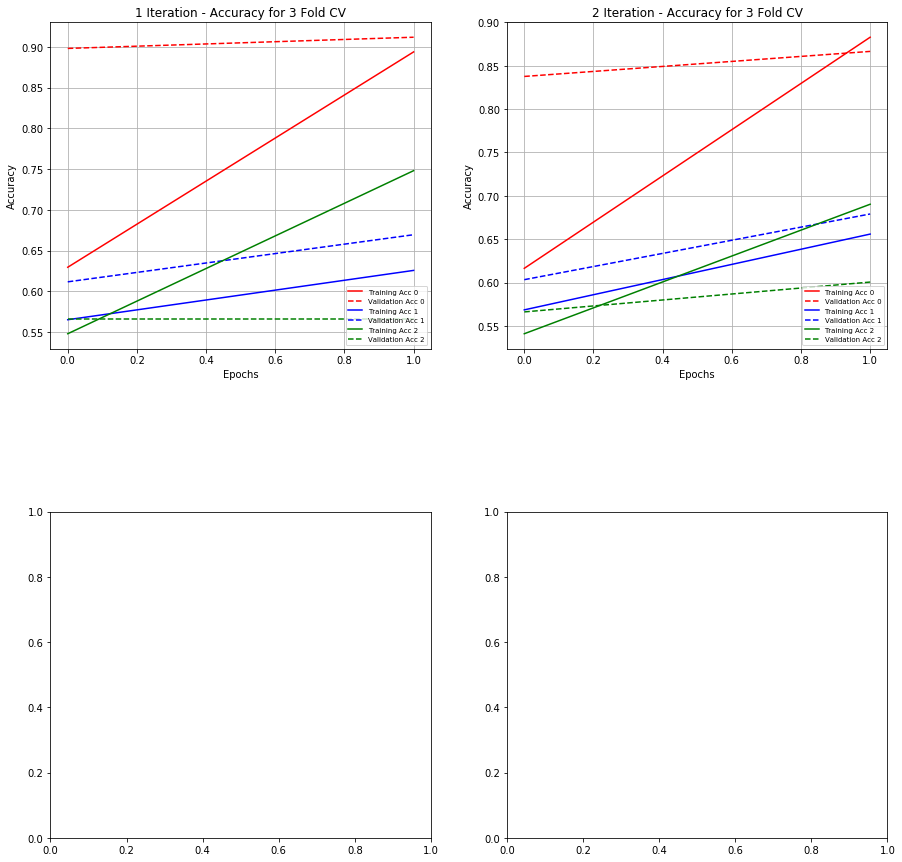

In [108]:
fargs = {'num_classes': 2, 'optimizer': keras.optimizers.Adagrad()}
fitargs = {'batch_size': 64, 'epochs': 2, 'callbacks': [early_stop], 'verbose': 1}
history_info_adagrad_64 = cross_validation_score(K=3, N=2, X_train=X_train, y_train=y_train, 
                                      f_model=cnn_model, f_args=fargs, fit_args=fitargs)
history_plot.history_plot_cv(history_info_adagrad_64, "history_info_adagrad_64_", "show", K=3, N=2)

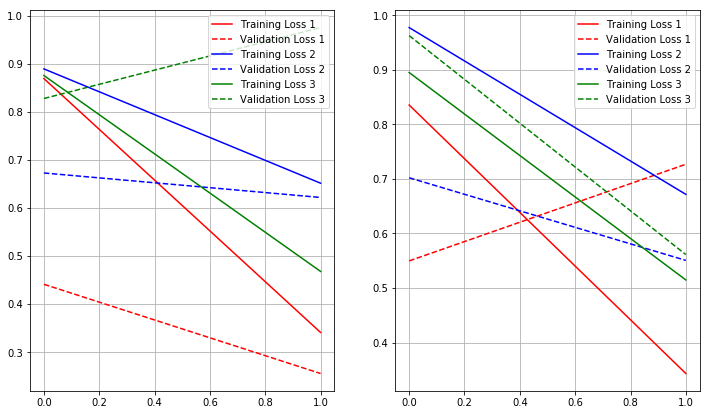

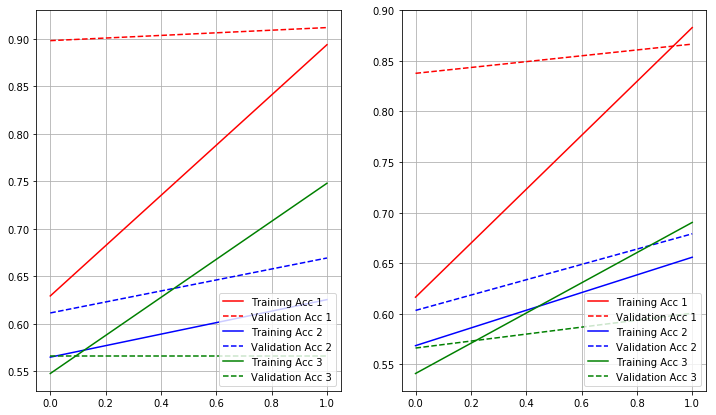

In [138]:
import history_plot
reload(history_plot)
history_plot.history_plot_cv(history_info_adagrad_64, "history_info_adagrad_64_", "show", K=3, N=2)

In [24]:
epchs = 20
batch = 64
splits = 3

#cnn cnn model
skf = StratifiedKFold(n_splits=splits)
best_validation_acc = 0.0
best_model = None
num_classes = 2
histories_cnn=[]
for i, (train_index, validation_index) in enumerate(skf.split(X_train, Y_train)):
    print("Test nr.: %d/%d"%(i+1, splits))
    
    Xtrain, Xvalidation = X_train[train_index], X_train[validation_index]
    ytrain, yvalidation = Y_train[train_index], Y_train[validation_index]
    model = cnn_model(num_classes=2, optimizer=keras.optimizers.Adagrad())
    Ytrain = np_utils.to_categorical(ytrain)
    Yvalidation = np_utils.to_categorical(yvalidation)

    history = model.fit(Xtrain, Ytrain, batch_size=batch,
                        epochs=epchs, verbose=1, callbacks=[early_stop],
                        validation_data = (Xvalidation, Yvalidation), shuffle=False)
    histories_cnn.append(history)
    training_acc = history.history['acc']
    validation_acc = history.history['val_acc']
    print("Training acc: %f, Validation acc: %f" %(np.max(training_acc),np.max(validation_acc)))
    if validation_acc > best_validation_acc:
        best_validation_acc = validation_acc
        best_model = model

Ytrain = np_utils.to_categorical(ytrain)
best_history = best_model.fit(Xtrain, Ytrain, batch_size=batch, epochs=epchs)  # replicate conf.

predictions = best_model.predict(X_test)
cls_predictions = np.argmax(predictions, axis=1)

from sklearn.metrics import accuracy_score
score = accuracy_score(Y_test, cls_predictions)
print("Accuracy score: ", score)

NameError: name 'Y_train' is not defined

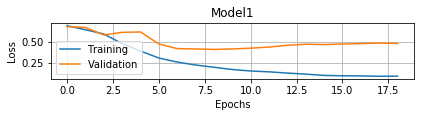

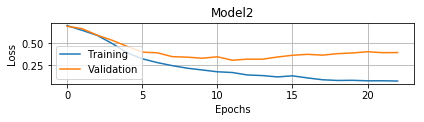

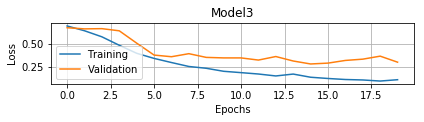

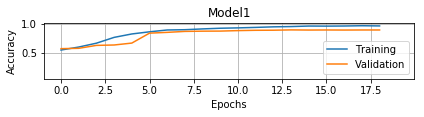

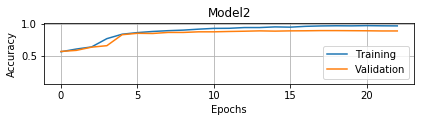

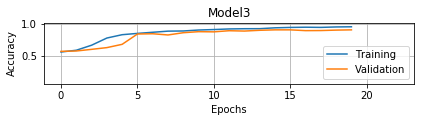

In [245]:
history_plot(histories_cnn100, "histories_cnn_cb", "show")

In [20]:
StratifiedKFold?

In [59]:
epchs = 50
batch = 32
splits = 5

#cnn cnn model
skf = StratifiedKFold(n_splits=splits)
best_validation_acc = 0.0
best_model = None
num_classes = 2
histories_cnn=[]
for i, (train_index, validation_index) in enumerate(skf.split(X_train, Y_train)):
    test = i+1
    print("Test nr.: %d/%d"%(test, splits))
    print("Nr of training samples: %d Nr of validation samples: %d" %(train_index.size, validation_index.size))

    Xtrain, Xvalidation = X_train[train_index], X_train[validation_index]
    ytrain, yvalidation = Y_train[train_index], Y_train[validation_index]
    model = create_nn_model()
    Ytrain = np_utils.to_categorical(ytrain)
    Yvalidation = np_utils.to_categorical(yvalidation)

    history = model.fit(Xtrain, Ytrain, batch_size=batch,
                        epochs=epchs, verbose=1, callbacks=[reduce_lr],
                        validation_data = (Xvalidation, Yvalidation), shuffle=False)
    histories_cnn.append(history)
    training_acc = history.history['acc']
    validation_acc = history.history['val_acc']
    print("Training acc: %f, Validation acc: %f" %(training_acc[-1],validation_acc[-1]))
    if validation_acc > best_validation_acc:
        best_validation_acc = validation_acc
        best_model = model
        b_history = history
        j = test
        
Ytrain = np_utils.to_categorical(Y_train)
print("Best model is: %d"%(j))
print("Train best model on the whole train dataset - no validation")
repl_history = best_model.fit(X_train, Ytrain, batch_size=batch, epochs=epchs, callbacks=[reduce_lr_noval])  # replicate conf.
best_model.save_weights("best_model_weights_sgd.h5")

print("Use best model to make prediction on test data")
predictions = best_model.predict(X_test)
cls_predictions = np.argmax(predictions, axis=1)

from sklearn.metrics import accuracy_score
score = accuracy_score(Y_test, cls_predictions)
print("Accuracy score: ", score)
history_plot(histories_cnn[j-1], "histories_cnn_sgd", "both")
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(Y_test, cls_predictions)

print("Confusion matrix: ")
print(conf_matrix)

print("indices of the wrongly classified events: ")
print(indx2[np.where(cls_predictions!=Y_test)])

Test nr.: 1/5
Nr of training samples: 1742 Nr of validation samples: 437
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 128, 14, 13, 16)   259328    
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 64, 12, 11, 14)    221248    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 64, 6, 5, 7)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 6, 5, 7)       0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 32, 4, 3, 5)       55328     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 4, 3, 5)       0         
_________________________________________________________________
con

1743/1743 [==============================] - 10s - loss: 0.1600 - acc: 0.9398 - val_loss: 0.5956 - val_acc: 0.8257
Epoch 50/50
1743/1743 [==============================] - 9s - loss: 0.1547 - acc: 0.9415 - val_loss: 0.5944 - val_acc: 0.8211
Training acc: 0.941480, Validation acc: 0.821101
Test nr.: 3/5
Nr of training samples: 1743 Nr of validation samples: 436
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 128, 14, 13, 16)   259328    
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 64, 12, 11, 14)    221248    
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 64, 6, 5, 7)       0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 64, 6, 5, 7)       0         
___________________________________________

1744/1744 [==============================] - 9s - loss: 0.2237 - acc: 0.9100 - val_loss: 0.3877 - val_acc: 0.8460
Epoch 48/50
1744/1744 [==============================] - 9s - loss: 0.2174 - acc: 0.9117 - val_loss: 0.3876 - val_acc: 0.8483
Epoch 49/50
1744/1744 [==============================] - 9s - loss: 0.2249 - acc: 0.9065 - val_loss: 0.3867 - val_acc: 0.8437
Epoch 50/50
1744/1744 [==============================] - 9s - loss: 0.2216 - acc: 0.9100 - val_loss: 0.3860 - val_acc: 0.8483
Training acc: 0.909977, Validation acc: 0.848276
Test nr.: 5/5
Nr of training samples: 1744 Nr of validation samples: 435
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_17 (Conv3D)           (None, 128, 14, 13, 16)   259328    
_________________________________________________________________
conv3d_18 (Conv3D)           (None, 64, 12, 11, 14)    221248    
________________________________________________________

ImportError: `save_weights` requires h5py.

Use best model to make prediction on test data
('Accuracy score: ', 0.88623853211009174)


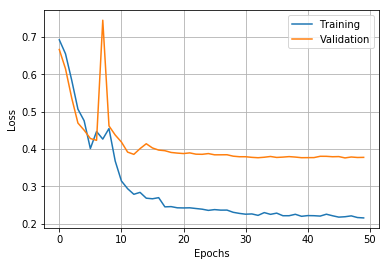

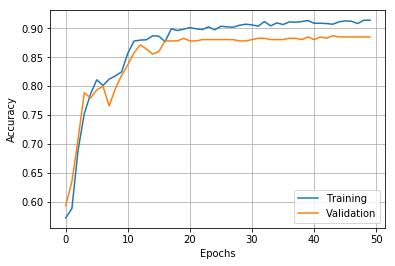

Confusion matrix: 
[[223  12]
 [ 50 260]]
indices of the wrongly classified events: 
[1533  291 1057 2073  420  296 2585  387 1620  282 1742  761  807 1286 1538
  941  270  124  233  528   63 1431  649  471  170 1289 1449  149  463  821
  527  152  408  879  210  651  789 1374 1053  900 1292  218 1550 2642  102
  402 1071 1047 1228 2470  414 1268 1801 1461  443 1814 2050 1290 1173  610
 1743 2021]


In [60]:
print("Use best model to make prediction on test data")
predictions = best_model.predict(X_test)
cls_predictions = np.argmax(predictions, axis=1)

from sklearn.metrics import accuracy_score
score = accuracy_score(Y_test, cls_predictions)
print("Accuracy score: ", score)
history_plot(histories_cnn[j-1], "histories_cnn_sgd", "both")
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(Y_test, cls_predictions)

print("Confusion matrix: ")
print(conf_matrix)

print("indices of the wrongly classified events: ")
print(indx2[np.where(cls_predictions!=Y_test)])

Test nr.: 1/5
Nr of training samples: 1742 Nr of validation samples: 437
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 128, 14, 13, 16)   259328    
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 64, 12, 11, 14)    221248    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 64, 6, 5, 7)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 6, 5, 7)       0         
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 32, 4, 3, 5)       55328     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 4, 3, 5)       0         
_________________________________________________________________
con

1743/1743 [==============================] - 8s - loss: 0.2042 - acc: 0.9168 - val_loss: 0.6223 - val_acc: 0.8372
Epoch 50/50
1743/1743 [==============================] - 8s - loss: 0.2024 - acc: 0.9157 - val_loss: 0.6213 - val_acc: 0.8372
Training acc: 0.915663, Validation acc: 0.837156
Test nr.: 3/5
Nr of training samples: 1743 Nr of validation samples: 436
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 128, 14, 13, 16)   259328    
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 64, 12, 11, 14)    221248    
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 64, 6, 5, 7)       0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 64, 6, 5, 7)       0         
____________________________________________

1744/1744 [==============================] - 8s - loss: 0.3224 - acc: 0.8515 - val_loss: 0.4328 - val_acc: 0.8276
Epoch 48/50
1744/1744 [==============================] - 8s - loss: 0.3275 - acc: 0.8458 - val_loss: 0.4324 - val_acc: 0.8276
Epoch 49/50
1744/1744 [==============================] - 8s - loss: 0.3267 - acc: 0.8509 - val_loss: 0.4322 - val_acc: 0.8276
Epoch 50/50
1744/1744 [==============================] - 8s - loss: 0.3226 - acc: 0.8572 - val_loss: 0.4318 - val_acc: 0.8253
Training acc: 0.857225, Validation acc: 0.825287
Test nr.: 5/5
Nr of training samples: 1744 Nr of validation samples: 435
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_17 (Conv3D)           (None, 128, 14, 13, 16)   259328    
_________________________________________________________________
conv3d_18 (Conv3D)           (None, 64, 12, 11, 14)    221248    
________________________________________________________

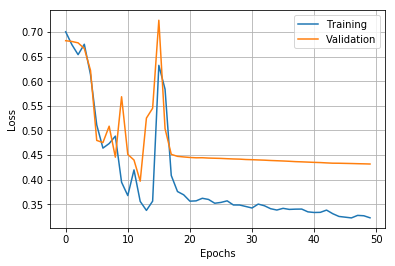

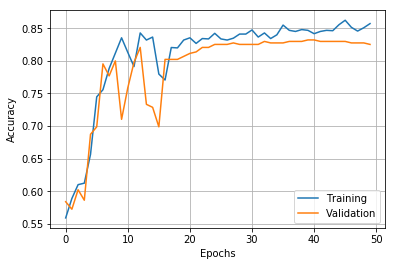

Confusion matrix: 
[[205  30]
 [ 75 235]]
indices of the wrongly classified events: 
[1533  291 1057 1221 2073   73  420  296 1260 2585  387 1270 2524 1429  282
 1742  211  761 2424  807 1286  321 1538 1475  941  944  270  124  233 1637
  486   63 1088 1949 1200 1591  649  471  170 1289 1449 1207  149  463 2089
  821  527  152  408 1494  879  210  632  976  651  789 1374  199 1053  289
 2656 2681 1622  900 1017  226  705 2072 2064 2596 1550 1241  867 1226 2642
 2122  102  402 1071 2185 1047 1228 2470  414 1268 1865 1266 1084 1801 2484
 1866 1461  443 1814 2600 2050 1290 2561  841 1173  610 1743 1410 2021  347]


In [64]:
#SGD, Nesterov False
epchs = 50
batch = 32
splits = 5

#cnn cnn model
skf = StratifiedKFold(n_splits=splits)
best_validation_acc = 0.0
best_model = None
num_classes = 2
histories_cnn=[]
for i, (train_index, validation_index) in enumerate(skf.split(X_train, Y_train)):
    test = i+1
    print("Test nr.: %d/%d"%(test, splits))
    print("Nr of training samples: %d Nr of validation samples: %d" %(train_index.size, validation_index.size))

    Xtrain, Xvalidation = X_train[train_index], X_train[validation_index]
    ytrain, yvalidation = Y_train[train_index], Y_train[validation_index]
    model = create_nn_model()
    Ytrain = np_utils.to_categorical(ytrain)
    Yvalidation = np_utils.to_categorical(yvalidation)

    history = model.fit(Xtrain, Ytrain, batch_size=batch,
                        epochs=epchs, verbose=1, callbacks=[reduce_lr],
                        validation_data = (Xvalidation, Yvalidation), shuffle=False)
    histories_cnn.append(history)
    training_acc = history.history['acc']
    validation_acc = history.history['val_acc']
    print("Training acc: %f, Validation acc: %f" %(training_acc[-1],validation_acc[-1]))
    if validation_acc > best_validation_acc:
        best_validation_acc = validation_acc
        best_model = model
        b_history = history
        j = test
        
Ytrain = np_utils.to_categorical(Y_train)
print("Best model is: %d"%(j))
print("Train best model on the whole train dataset - no validation")
repl_history = best_model.fit(X_train, Ytrain, batch_size=batch, epochs=epchs, callbacks=[reduce_lr_noval])  # replicate conf.
#best_model.save_weights("best_model_weights_sgd.h5")

print("Use best model to make prediction on test data")
predictions = best_model.predict(X_test)
cls_predictions = np.argmax(predictions, axis=1)

from sklearn.metrics import accuracy_score
score = accuracy_score(Y_test, cls_predictions)
print("Accuracy score: ", score)
history_plot(histories_cnn[j-1], "histories_cnn_sgd_nest_false", "both")
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(Y_test, cls_predictions)

print("Confusion matrix: ")
print(conf_matrix)

print("indices of the wrongly classified events: ")
print(indx2[np.where(cls_predictions!=Y_test)])

Test nr.: 1/5
Nr of training samples: 1742 Nr of validation samples: 437
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_5 (Conv3D)            (None, 128, 14, 13, 16)   259328    
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 64, 12, 11, 14)    221248    
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 64, 6, 5, 7)       0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 64, 6, 5, 7)       0         
_________________________________________________________________
conv3d_7 (Conv3D)            (None, 32, 4, 3, 5)       55328     
_________________________________________________________________
dropout_4 (Dropout)          (None, 32, 4, 3, 5)       0         
_________________________________________________________________
con

1743/1743 [==============================] - 9s - loss: 0.5001 - acc: 0.7717 - val_loss: 0.6784 - val_acc: 0.6972
Epoch 50/50
1743/1743 [==============================] - 9s - loss: 0.4967 - acc: 0.7797 - val_loss: 0.6786 - val_acc: 0.6904
Training acc: 0.779690, Validation acc: 0.690367
Test nr.: 3/5
Nr of training samples: 1743 Nr of validation samples: 436
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_13 (Conv3D)           (None, 128, 14, 13, 16)   259328    
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 64, 12, 11, 14)    221248    
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 64, 6, 5, 7)       0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 64, 6, 5, 7)       0         
____________________________________________

1744/1744 [==============================] - 9s - loss: 0.2541 - acc: 0.9008 - val_loss: 0.3829 - val_acc: 0.8391
Epoch 48/50
1744/1744 [==============================] - 9s - loss: 0.2534 - acc: 0.8985 - val_loss: 0.3825 - val_acc: 0.8414
Epoch 49/50
1744/1744 [==============================] - 9s - loss: 0.2558 - acc: 0.8979 - val_loss: 0.3816 - val_acc: 0.8437
Epoch 50/50
1744/1744 [==============================] - 9s - loss: 0.2548 - acc: 0.8951 - val_loss: 0.3815 - val_acc: 0.8437
Training acc: 0.895069, Validation acc: 0.843678
Test nr.: 5/5
Nr of training samples: 1744 Nr of validation samples: 435
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_21 (Conv3D)           (None, 128, 14, 13, 16)   259328    
_________________________________________________________________
conv3d_22 (Conv3D)           (None, 64, 12, 11, 14)    221248    
________________________________________________________

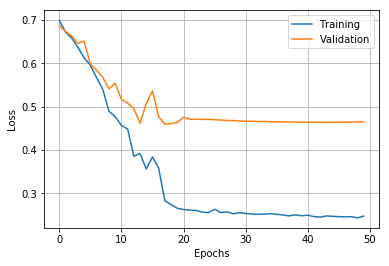

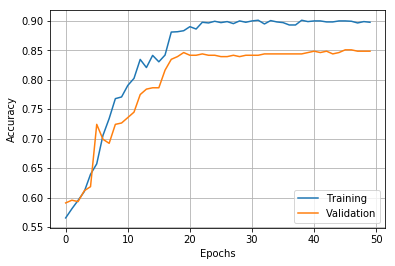

Confusion matrix: 
[[216  19]
 [ 52 258]]
indices of the wrongly classified events: 
[ 291 1057 2073  420  518  387 2256  655  282 1742  761 1376  807 1538  941
  124  233 1637   63 1431 1949  649  471 1289 1207  149  134  463  809  527
  152 1058  408  879  210  789  990  199 1053 2681  900  231 1292  218 1748
 1550 2642  102  402  259 1071 2185 1047 1228 2470 2397 1268 1801 1866 1461
 1814  457 1290 2561 1173 1738  610 1743  772 2021  940]


In [69]:
#SGD, momentum 0.5 Nesterov True
epchs = 50
batch = 32
splits = 5

#cnn cnn model
skf = StratifiedKFold(n_splits=splits)
best_validation_acc = 0.0
best_model = None
num_classes = 2
histories_cnn=[]
for i, (train_index, validation_index) in enumerate(skf.split(X_train, Y_train)):
    test = i+1
    print("Test nr.: %d/%d"%(test, splits))
    print("Nr of training samples: %d Nr of validation samples: %d" %(train_index.size, validation_index.size))

    Xtrain, Xvalidation = X_train[train_index], X_train[validation_index]
    ytrain, yvalidation = Y_train[train_index], Y_train[validation_index]
    model = create_nn_model()
    Ytrain = np_utils.to_categorical(ytrain)
    Yvalidation = np_utils.to_categorical(yvalidation)

    history = model.fit(Xtrain, Ytrain, batch_size=batch,
                        epochs=epchs, verbose=1, callbacks=[reduce_lr],
                        validation_data = (Xvalidation, Yvalidation), shuffle=False)
    histories_cnn.append(history)
    training_acc = history.history['acc']
    validation_acc = history.history['val_acc']
    print("Training acc: %f, Validation acc: %f" %(training_acc[-1],validation_acc[-1]))
    if validation_acc > best_validation_acc:
        best_validation_acc = validation_acc
        best_model = model
        b_history = history
        j = test
        
Ytrain = np_utils.to_categorical(Y_train)
print("Best model is: %d"%(j))
print("Train best model on the whole train dataset - no validation")
repl_history = best_model.fit(X_train, Ytrain, batch_size=batch, epochs=epchs, callbacks=[reduce_lr_noval])  # replicate conf.
#best_model.save_weights("best_model_weights_sgd.h5")

print("Use best model to make prediction on test data")
predictions = best_model.predict(X_test)
cls_predictions = np.argmax(predictions, axis=1)

from sklearn.metrics import accuracy_score
score = accuracy_score(Y_test, cls_predictions)
print("Accuracy score: ", score)
history_plot(histories_cnn[j-1], "histories_cnn_sgd_nest_mom_05", "both")
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(Y_test, cls_predictions)

print("Confusion matrix: ")
print(conf_matrix)

print("indices of the wrongly classified events: ")
print(indx2[np.where(cls_predictions!=Y_test)])

In [31]:
wrong_class_evt = np.asarray([1533, 291, 1057, 2073, 420, 296, 2585, 387, 1620, 282, 1742, 761, 807, 1286, 1538, 
                   941, 270, 124, 233, 528, 63, 1431, 649, 471, 170, 1289, 1449, 149, 463, 821,
                   527, 152, 408, 879, 210, 651, 789, 1374, 1053, 900, 1292, 218, 1550, 2642, 102,
                   402, 1071, 1047, 1228, 2470, 414, 1268, 1801, 1461, 443, 1814, 2050, 1290, 1173, 610,
                   1743, 2021])

In [32]:
wrong_class_evt_numu = wrong_class_evt[wrong_class_evt<1541]

In [33]:
wrong_class_evt_nue = wrong_class_evt[wrong_class_evt>1541] - 1541

In [34]:
print(wrong_class_evt_numu, wrong_class_evt_nue)

(array([1533,  291, 1057,  420,  296,  387,  282,  761,  807, 1286, 1538,
        941,  270,  124,  233,  528,   63, 1431,  649,  471,  170, 1289,
       1449,  149,  463,  821,  527,  152,  408,  879,  210,  651,  789,
       1374, 1053,  900, 1292,  218,  102,  402, 1071, 1047, 1228,  414,
       1268, 1461,  443, 1290, 1173,  610]), array([ 532, 1044,   79,  201,    9, 1101,  929,  260,  273,  509,  202,
        480]))


In [35]:
numufile = "utilities/km3_v4_numucc_1_B.evt.aa.root"
nuefile = "utilities/km3_v4_nuecc_1.evt.JTE.aa.root"

In [37]:
import ROOT
import root_numpy as rnp

In [42]:
E_numu = rnp.root2array(numufile, treename='E', branches='Evt.mc_trks.E')
type_numu = rnp.root2array(numufile, treename='E', branches = 'Evt.mc_trks.type')
E_nue = rnp.root2array(nuefile, treename='E', branches='Evt.mc_trks.E')
type_nue = rnp.root2array(nuefile, treename='E', branches = 'Evt.mc_trks.type')


E_numu_ = np.asarray([E_numu[evt][type_numu[evt]==5][0]for evt in range(E_numu.shape[0])])

E_nue_ = np.asarray([E_nue[evt][type_nue[evt]==3][0]for evt in range(E_nue.shape[0])])


In [43]:
E_numu_[wrong_class_evt_numu]
E_nue_[wrong_class_evt_nue]

array([  1.90957000e+03,   1.09228000e+05,   4.65138000e+02,
         3.99701000e+02,   2.65401000e+01,   5.63944000e+05,
         1.51784000e+05,   5.16465000e+02,   5.25111000e+01,
         2.45945000e+02,   2.94812000e+02,   5.55735000e+02])

In [47]:
nbins = 12
log_MC_en = np.log10(E_numu_) 
log_minE = np.min(log_MC_en) #np.log10(np.int(np.min(montecarlo_energies)))
log_maxE = np.max(log_MC_en) #np.log10(np.int(np.max(montecarlo_energies)))
        
log_evts = np.log10(wrong_class_evt_numu) 
    #binned log energies calculation with np.histogram
MC_events_per_bin, _ = np.histogram(log_MC_en, bins=nbins, range=(log_minE, log_maxE))
wrong_evts_per_bin, energy_bins = np.histogram(log_evts, bins=nbins, range=(log_minE,log_maxE))

In [49]:
fraction = np.true_divide(wrong_evts_per_bin, MC_events_per_bin)

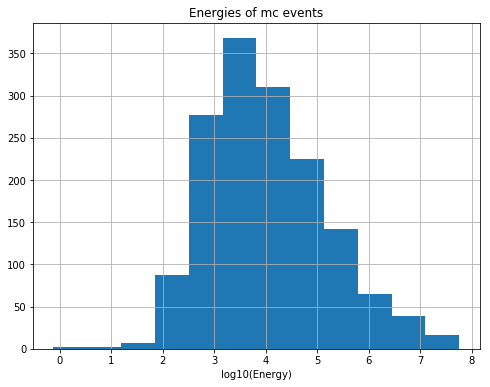

In [65]:
% matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
#plt.hist(np.log10(E_numu_[wrong_class_evt_numu]), normed=False, facecolor='g', alpha=0.75, label="numu")
#plt.hist(np.log10(E_nue_[wrong_class_evt_nue]), normed=False,  facecolor="blue", alpha=0.5, label="nue")
#plt.hist(np.log10(E_numu_), normed=False, facecolor='b', alpha=0.5, label="numu")
#plt.plot(energy_bins[1:], fraction)
plt.hist(np.log10(E_numu_), bins=energy_bins)
plt.xlabel("log10(Energy)")
#plt.ylabel("(misclassified_evts)/MC_evts", size=15)
plt.xscale("linear")
plt.title('Energies of mc events')
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

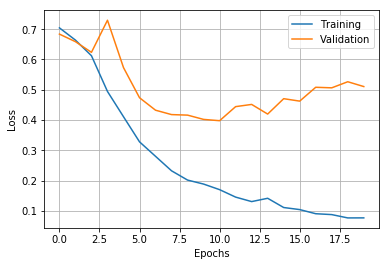

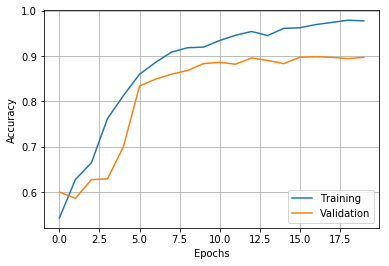

In [59]:
history_plot(histories_cnn[0], "histories_cnn_conf", "show")

Test nr.: 1/5
Nr of training samples: 1742 Nr of validation samples: 437
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 128, 14, 13, 16)   259328    
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 64, 12, 11, 14)    221248    
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 64, 6, 5, 7)       0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 64, 6, 5, 7)       0         
_________________________________________________________________
conv3d_11 (Conv3D)           (None, 32, 4, 3, 5)       55328     
_________________________________________________________________
dropout_6 (Dropout)          (None, 32, 4, 3, 5)       0         
_________________________________________________________________
con

2179/2179 [==============================] - 11s - loss: 0.0833 - acc: 0.9867    
Epoch 13/50
2179/2179 [==============================] - 11s - loss: 0.0725 - acc: 0.9917    
Epoch 14/50
2179/2179 [==============================] - 11s - loss: 0.0730 - acc: 0.9899    
Epoch 15/50
2179/2179 [==============================] - 11s - loss: 0.0693 - acc: 0.9927    
Epoch 16/50
2179/2179 [==============================] - 11s - loss: 0.0754 - acc: 0.9927    
Epoch 17/50
2179/2179 [==============================] - 11s - loss: 0.0664 - acc: 0.9927    
Epoch 18/50
2179/2179 [==============================] - 11s - loss: 0.0729 - acc: 0.9927    
Epoch 19/50
2179/2179 [==============================] - 11s - loss: 0.0723 - acc: 0.9922    
Epoch 20/50
2179/2179 [==============================] - 11s - loss: 0.0626 - acc: 0.9950    
Epoch 21/50
2179/2179 [==============================] - 11s - loss: 0.0624 - acc: 0.9931    
Epoch 22/50
2179/2179 [==============================] - 11s - loss: 0.0

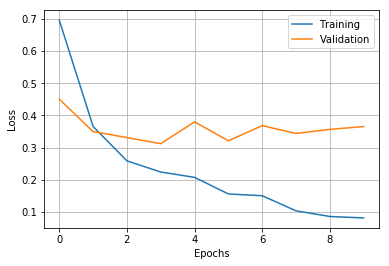

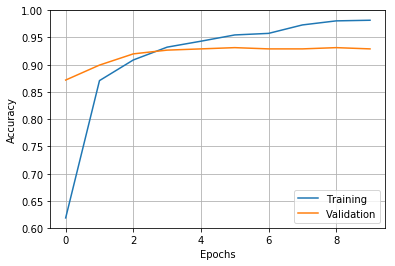

Confusion matrix: 
[[216  19]
 [ 20 290]]
indices of the wrongly classified events: 
[1057 2073 1628 2585 1876  387 2256 2524  761  807 1677  439 1934 1538   70
  124  528   63 1431 1591 1289 2303  149  527  879  210 1053 2681  900 1292
 2064 1797 2397 1801 1461 1584 2600 2537 2021]


In [135]:
#RMSProp + early stop
epchs = 50
batch = 32
splits = 5

#cnn cnn model
skf = StratifiedKFold(n_splits=splits)
best_validation_acc = 0.0
best_model = None
num_classes = 2
histories_cnn=[]
for i, (train_index, validation_index) in enumerate(skf.split(X_train, Y_train)):
    test = i+1
    print("Test nr.: %d/%d"%(test, splits))
    print("Nr of training samples: %d Nr of validation samples: %d" %(train_index.size, validation_index.size))

    Xtrain, Xvalidation = X_train[train_index], X_train[validation_index]
    ytrain, yvalidation = Y_train[train_index], Y_train[validation_index]
    model = create_nn_model()
    Ytrain = np_utils.to_categorical(ytrain)
    Yvalidation = np_utils.to_categorical(yvalidation)

    history = model.fit(Xtrain, Ytrain, batch_size=batch,
                        epochs=epchs, verbose=1, callbacks=[reduce_lr, early_stop],
                        validation_data = (Xvalidation, Yvalidation), shuffle=False)
    histories_cnn.append(history)
    training_acc = history.history['acc']
    validation_acc = history.history['val_acc']
    print("Training acc: %f, Validation acc: %f" %(training_acc[-1],validation_acc[-1]))
    if validation_acc > best_validation_acc:
        best_validation_acc = validation_acc
        best_model = model
        b_history = history
        j = test
        
Ytrain = np_utils.to_categorical(Y_train)
print("Best model is: %d"%(j))
print("Train best model on the whole train dataset - no validation")
repl_history = best_model.fit(X_train, Ytrain, batch_size=batch, epochs=epchs, callbacks=[reduce_lr_noval, early_stop_noval])  # replicate conf.
#best_model.save_weights("best_model_weights_sgd.h5")

print("Use best model to make prediction on test data")
predictions = best_model.predict(X_test)
cls_predictions = np.argmax(predictions, axis=1)

from sklearn.metrics import accuracy_score
score = accuracy_score(Y_test, cls_predictions)
print("Accuracy score: ", score)
history_plot(histories_cnn[j-1], "histories_cnn_RMSProp", "both")
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(Y_test, cls_predictions)

print("Confusion matrix: ")
print(conf_matrix)

print("indices of the wrongly classified events: ")
print(indx2[np.where(cls_predictions!=Y_test)])

Test nr.: 1/5
Nr of training samples: 1742 Nr of validation samples: 437
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_29 (Conv3D)           (None, 128, 14, 13, 16)   259328    
_________________________________________________________________
conv3d_30 (Conv3D)           (None, 64, 12, 11, 14)    221248    
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 64, 6, 5, 7)       0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 64, 6, 5, 7)       0         
_________________________________________________________________
conv3d_31 (Conv3D)           (None, 32, 4, 3, 5)       55328     
_________________________________________________________________
dropout_16 (Dropout)         (None, 32, 4, 3, 5)       0         
_________________________________________________________________
con

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_33 (Conv3D)           (None, 128, 14, 13, 16)   259328    
_________________________________________________________________
conv3d_34 (Conv3D)           (None, 64, 12, 11, 14)    221248    
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 64, 6, 5, 7)       0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 64, 6, 5, 7)       0         
_________________________________________________________________
conv3d_35 (Conv3D)           (None, 32, 4, 3, 5)       55328     
_________________________________________________________________
dropout_18 (Dropout)         (None, 32, 4, 3, 5)       0         
_________________________________________________________________
conv3d_36 (Conv3D)           (None, 32, 2, 1, 3)       27680     
__________

Train on 1743 samples, validate on 436 samples
Epoch 1/50
1743/1743 [==============================] - 10s - loss: 0.6872 - acc: 0.5789 - val_loss: 0.6009 - val_acc: 0.6468
Epoch 2/50
1743/1743 [==============================] - 9s - loss: 0.3994 - acc: 0.8508 - val_loss: 0.2788 - val_acc: 0.8968
Epoch 3/50
1743/1743 [==============================] - 10s - loss: 0.2405 - acc: 0.9139 - val_loss: 0.2571 - val_acc: 0.9128
Epoch 4/50
1743/1743 [==============================] - 9s - loss: 0.1822 - acc: 0.9363 - val_loss: 0.3103 - val_acc: 0.9106
Epoch 5/50
1743/1743 [==============================] - 9s - loss: 0.1370 - acc: 0.9518 - val_loss: 0.2861 - val_acc: 0.9197
Epoch 6/50
1728/1743 [============================>.] - ETA: 0s - loss: 0.1057 - acc: 0.9647
Epoch 00005: reducing learning rate to 0.00010000000475.
1743/1743 [==============================] - 10s - loss: 0.1049 - acc: 0.9650 - val_loss: 0.3319 - val_acc: 0.9197
Epoch 7/50
1743/1743 [==============================] - 10s -

1744/1744 [==============================] - 10s - loss: 0.6870 - acc: 0.5671 - val_loss: 0.5567 - val_acc: 0.6184
Epoch 2/50
1744/1744 [==============================] - 10s - loss: 0.4497 - acc: 0.8182 - val_loss: 0.2446 - val_acc: 0.9080
Epoch 3/50
1744/1744 [==============================] - 10s - loss: 0.2722 - acc: 0.8956 - val_loss: 0.2299 - val_acc: 0.9149
Epoch 4/50
1744/1744 [==============================] - 10s - loss: 0.2222 - acc: 0.9209 - val_loss: 0.2407 - val_acc: 0.9126
Epoch 5/50
1744/1744 [==============================] - 10s - loss: 0.1894 - acc: 0.9323 - val_loss: 0.2745 - val_acc: 0.9195
Epoch 6/50
1728/1744 [============================>.] - ETA: 0s - loss: 0.1255 - acc: 0.9554
Epoch 00005: reducing learning rate to 0.00010000000475.
1744/1744 [==============================] - 10s - loss: 0.1244 - acc: 0.9558 - val_loss: 0.3732 - val_acc: 0.9080
Epoch 7/50
1744/1744 [==============================] - 9s - loss: 0.1330 - acc: 0.9650 - val_loss: 0.2843 - val_acc

2179/2179 [==============================] - 11s - loss: 0.0701 - acc: 0.9950    
Epoch 19/50
2179/2179 [==============================] - 11s - loss: 0.0691 - acc: 0.9954    
Epoch 20/50
2179/2179 [==============================] - 11s - loss: 0.0780 - acc: 0.9940    
Epoch 21/50
2179/2179 [==============================] - 11s - loss: 0.0772 - acc: 0.9940    
Epoch 22/50
2179/2179 [==============================] - 11s - loss: 0.0755 - acc: 0.9950    
Epoch 23/50
2179/2179 [==============================] - 11s - loss: 0.0781 - acc: 0.9945    
Epoch 24/50
2179/2179 [==============================] - 11s - loss: 0.0674 - acc: 0.9959    
Epoch 25/50
2179/2179 [==============================] - 11s - loss: 0.0675 - acc: 0.9959    
Epoch 26/50
2179/2179 [==============================] - 11s - loss: 0.0673 - acc: 0.9959    
Epoch 27/50
2179/2179 [==============================] - 11s - loss: 0.0669 - acc: 0.9959    
Epoch 28/50
2179/2179 [==============================] - 11s - loss: 0.0

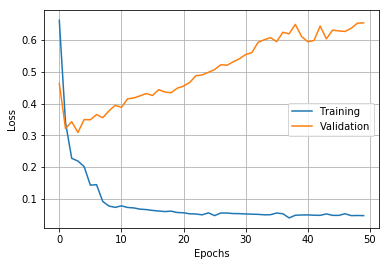

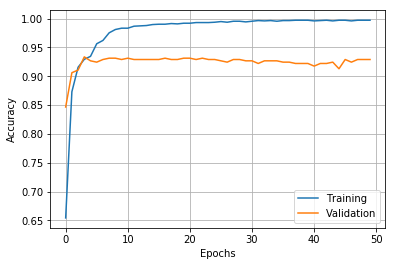

Confusion matrix: 
[[224  11]
 [ 22 288]]
indices of the wrongly classified events: 
[1057 2073 2585 1876  387 2524  211  761  407  807 1677  439 1538   70  124
  528   63 1431  471 2303  149  527  879  210 1053 2681  900 1292  402 2397
 1801 2600 2021]


In [150]:
#RMSProp
epchs = 50
batch = 32
K = 5

#cnn cnn model
skf = StratifiedKFold(n_splits=K)
best_validation_acc = 0.0
best_model = None
num_classes = 2
histories_cnn=[]
for i, (train_index, validation_index) in enumerate(skf.split(X_train, Y_train)):
    test = i+1
    print("Test nr.: %d/%d"%(test, K))
    print("Nr of training samples: %d Nr of validation samples: %d" %(train_index.size, validation_index.size))

    Xtrain, Xvalidation = X_train[train_index], X_train[validation_index]
    ytrain, yvalidation = Y_train[train_index], Y_train[validation_index]
    model = create_nn_model()
    Ytrain = np_utils.to_categorical(ytrain)
    Yvalidation = np_utils.to_categorical(yvalidation)

    history = model.fit(Xtrain, Ytrain, batch_size=batch,
                        epochs=epchs, verbose=1, callbacks=[reduce_lr],
                        validation_data = (Xvalidation, Yvalidation), shuffle=False)
    histories_cnn.append(history)
    training_acc = history.history['acc']
    validation_acc = history.history['val_acc']
    print("Training acc: %f, Validation acc: %f" %(training_acc[-1],validation_acc[-1]))
    if validation_acc > best_validation_acc:
        best_validation_acc = validation_acc
        best_model = model
        b_history = history
        j = test
        
Ytrain = np_utils.to_categorical(Y_train)
print("Best model is: %d"%(j))
print("Train best model on the whole train dataset - no validation")
repl_history = best_model.fit(X_train, Ytrain, batch_size=batch, epochs=epchs, callbacks=[reduce_lr_noval])  # replicate conf.
#best_model.save_weights("best_model_weights_sgd.h5")

print("Use best model to make prediction on test data")
predictions = best_model.predict(X_test)
cls_predictions = np.argmax(predictions, axis=1)

from sklearn.metrics import accuracy_score
score = accuracy_score(Y_test, cls_predictions)
print("Accuracy score: ", score)
history_plot(histories_cnn[j-1], "histories_cnn_RMSProp", "both")
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(Y_test, cls_predictions)

print("Confusion matrix: ")
print(conf_matrix)

print("indices of the wrongly classified events: ")
print(indx2[np.where(cls_predictions!=Y_test)])

In [63]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(Y_test, cls_predictions)

In [64]:
conf_matrix

array([[220,  15],
       [ 32, 278]])

In [40]:
indx2[np.where(cls_predictions!=Y_test)]

array([ 291, 1057, 1221, 2073,  420,  387,  282,  761,  407,  807,  439,
       1538,  270,  124,  233,  528,   63, 1431, 1591,  649,  471, 1289,
       2303,  149,  463,  527,  152,  408,  879,  210,  651,  789, 1053,
       2681,  900, 1292, 2642,  102,  402, 1071, 2470, 2397, 1801, 1461,
       1814, 2600, 2561,  610, 1743, 2021])

In [9]:
i=[]
j=[]
k=[]
for ii,x in enumerate(range(-300,1100,90)):
    for jj,y in enumerate(np.arange(-550,550, 45*np.sqrt(3))):
        for kk,z in enumerate(range(98,712,36)):
            i.append(ii)
            j.append(jj)
            k.append(kk)
        x-= 45
l_i = np.asarray(i)
l_j = np.asarray(j)
l_k = np.asarray(k)


arr = []
for i,j,k in zip(l_i,l_j,l_k):
    arr.append((i,j,k))
lol = np.asarray(arr)



In [18]:
bu = np.array([ 291, 1057, 1221, 2073,  420,  387,  282,  761,  407,  807,  439,
       1538,  270,  124,  233,  528,   63, 1431, 1591,  649,  471, 1289,
       2303,  149,  463,  527,  152,  408,  879,  210,  651,  789, 1053,
       2681,  900, 1292, 2642,  102,  402, 1071, 2470, 2397, 1801, 1461,
       1814, 2600, 2561,  610, 1743, 2021])

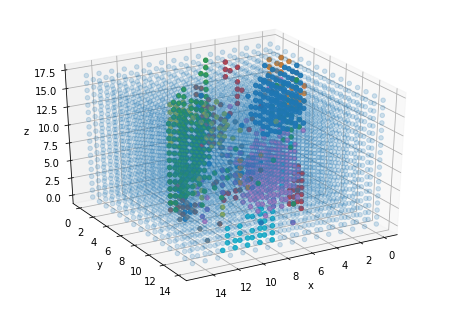

In [22]:
def plot_x_evt(evt):
    ggg = np.sum(X_numu[evt], axis=0)
    hhh = np.nonzero(ggg)
    return ax.scatter(hhh[0],hhh[1],hhh[2], alpha=0.9,label="evt {}".format(evt))

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
#ax.scatter(l_i, l_j, l_k , alpha=0.3)
ax.scatter(lol[:,0], lol[:,1], lol[:,2], alpha=0.2)
#ax.scatter(doms["x"], doms["y"], doms["z"], color="grey", alpha=0.02)
for i in bu[bu<1541]: 
    plot_x_evt(i)
ax.grid()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(30, 60)
plt.show()


In [33]:
cls_predictions.shape

(545,)

In [34]:
Y_test.shape

(545,)

In [28]:
from sklearn.metrics import confusion_matrix

In [31]:
cf_mx = confusion_matrix(Y_test, cls_predictions)

In [32]:
cf_mx

array([[217,  18],
       [ 26, 284]])

In [214]:
import matplotlib.pyplot as plt
from pylab import *
def history_plot(history, name, flag):
    subplots_adjust(hspace=0.2)
    number_of_subplots = len(history)

    for i,v in enumerate(range(number_of_subplots)):
        v = v+1
        ax1 = plt.subplot(number_of_subplots,1, v)
        ax1.plot(history[i].history['loss'])
        ax1.plot(history[i].history['val_loss'])
        ax1.set_title("Model"+str(v))
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax1.grid()
        ax1.legend(['Training', 'Validation'])
        plt.tight_layout()
        
        if flag=="save":
            plt.savefig("plots/Loss_"+name+".png")
        elif (flag=="show"):
            plt.show()
        elif (flag=="both"):
            plt.savefig("plots/Loss_"+name+".png")
            plt.show()

    for j,u in enumerate(range(number_of_subplots)):
        u = u+1

        ax2 = plt.subplot(number_of_subplots,1,u, sharex=ax1, sharey = ax1)
        ax2.plot(history[j].history['acc'])
        ax2.plot(history[j].history['val_acc'])
        ax2.set_title("Model"+str(u))
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Accuracy')
        ax2.grid()
        ax2.legend(['Training', 'Validation']) 
        plt.tight_layout()
        if flag=="save":
            plt.savefig("plots/Accuracy_"+name+".png")
        elif (flag=="show"):
            plt.show()
        elif (flag=="both"):
            plt.savefig("plots/Accuracy_"+name+".png")
            plt.show()

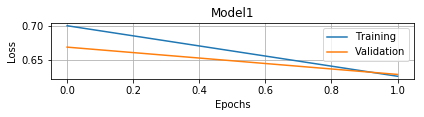

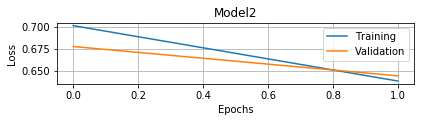

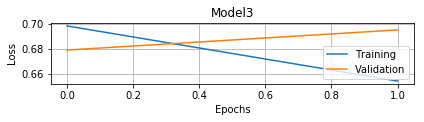

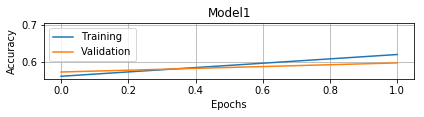

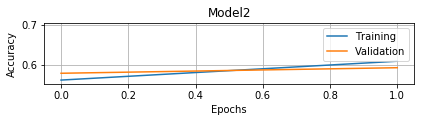

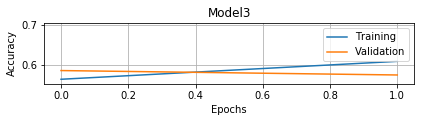

In [217]:
history_plot(histories_cnn100, "ggg", "show")

In [184]:
plt.subplots?

In [18]:
from sklearn.metrics import confusion_matrix

In [19]:
confusion_matrix?